##Data preparation, exploration, visualization

**Connect to GoogleDrive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
base_dir = '/content/gdrive/My Drive/MSDS-498/'
metadata_file = base_dir + 'metadata_compiled.csv'

audiofile_converted_path = base_dir + 'converted_files/'
audiofile_converted_sample_path = base_dir + 'sample/'

re_run = True

**Load Data**

In [ ]:
import pandas as pd
import numpy as np
import os

data = pd.read_csv(metadata_file)

# append path to .webm or .ogg
for item in os.scandir(base_dir + 'public_dataset'):
    if item.is_dir():
        for file in os.scandir(item):
            if file.is_file():
                file_split = os.path.splitext(file.name)
                if file_split[1] in ['.webm', '.ogg']:
                    data.loc[data.uuid == file_split[0], 'file_path'] = file.path

clean_data = None
data.head(5)

uuid  ...                                          file_path
0  00014dcc-0f06-4c27-8c7b-737b18a2cf4c  ...  /content/gdrive/My Drive/MSDS-498/public_datas...
1  00039425-7f3a-42aa-ac13-834aaa2b6b92  ...  /content/gdrive/My Drive/MSDS-498/public_datas...
2  0007c6f1-5441-40e6-9aaf-a761d8f2da3b  ...  /content/gdrive/My Drive/MSDS-498/public_datas...
3  0009eb28-d8be-4dc1-92bb-907e53bc5c7a  ...  /content/gdrive/My Drive/MSDS-498/public_datas...
4  0012c608-33d0-4ef7-bde3-75a0b1a0024e  ...  /content/gdrive/My Drive/MSDS-498/public_datas...

[5 rows x 52 columns]

Check the datatypes part of the dataset

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27550 entries, 0 to 27549
Data columns (total 52 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   27550 non-null  object 
 1   datetime               27550 non-null  object 
 2   cough_detected         27550 non-null  float64
 3   SNR                    27550 non-null  float64
 4   latitude               16084 non-null  float64
 5   longitude              16084 non-null  float64
 6   age                    15218 non-null  float64
 7   gender                 16224 non-null  object 
 8   respiratory_condition  16224 non-null  object 
 9   fever_muscle_pain      16224 non-null  object 
 10  status                 16224 non-null  object 
 11  quality_1              820 non-null    object 
 12  cough_type_1           802 non-null    object 
 13  dyspnea_1              820 non-null    object 
 14  wheezing_1             820 non-null    object 
 15  st

###Cleanup Missing Data

<function matplotlib.pyplot.show>

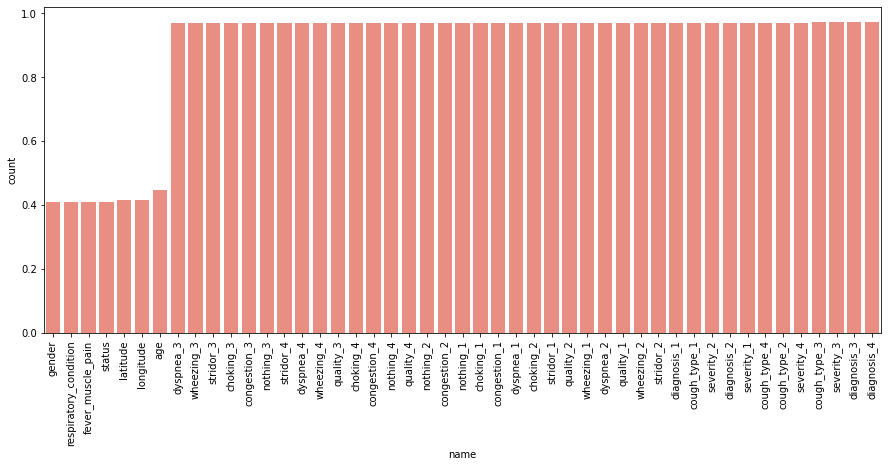

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# get percent of missing values
missing_values = data.isnull().sum() / len(data)
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True)

# convert to dataframe
missing_values = missing_values.to_frame()
missing_values.columns = ['count']
missing_values.index.names = ['name']
missing_values['name'] = missing_values.index

# plot graph
plt.subplots(figsize=(15,6))
sns.barplot(x='name', y='count', data=missing_values, color='salmon')
plt.xticks(rotation=90)
plt.show

Additional metadata is missing values and cannot be used. The result will be limited where missing data is < 50%

In [ ]:
useful_columns = []
for col in data.columns:
  if col not in missing_values.loc[missing_values['count'] > 0.5, 'name'].unique():
    useful_columns.append(col)


clean_data = data[useful_columns]
clean_data.head()

uuid  ...                                          file_path
0  00014dcc-0f06-4c27-8c7b-737b18a2cf4c  ...  /content/gdrive/My Drive/MSDS-498/public_datas...
1  00039425-7f3a-42aa-ac13-834aaa2b6b92  ...  /content/gdrive/My Drive/MSDS-498/public_datas...
2  0007c6f1-5441-40e6-9aaf-a761d8f2da3b  ...  /content/gdrive/My Drive/MSDS-498/public_datas...
3  0009eb28-d8be-4dc1-92bb-907e53bc5c7a  ...  /content/gdrive/My Drive/MSDS-498/public_datas...
4  0012c608-33d0-4ef7-bde3-75a0b1a0024e  ...  /content/gdrive/My Drive/MSDS-498/public_datas...

[5 rows x 12 columns]

In [ ]:
import os
import shutil

def reset_converted_files(target_dir):
  target_path = target_dir

  if os.path.isdir(target_path):
    shutil.rmtree(target_path)
  os.mkdir(target_path)

def convert_file(uuid, file_path, target_dir, verbose=True):
  if not os.path.isfile(file_path):
    print('Error: Could not convert file {} - does not exist'.format(audio_file))
    return None

  target_path = target_dir + uuid + '.wav'
  os.environ['source_path'] = file_path
  os.environ['target_path'] = target_path
  !ffmpeg -hide_banner -loglevel quiet -i "$source_path" "$target_path"

  if os.path.isfile(target_path):
    if verbose:
      print('Successfully converted: {}'.format(target_path))
  else:
    print('Error: Could not convert file with ffmpeg - {}'.format(file_path))

###Remove data that has a low cough detected and low signal to noise (SNR) levels

Text(0.5, 1.0, 'Histogram of SNR')

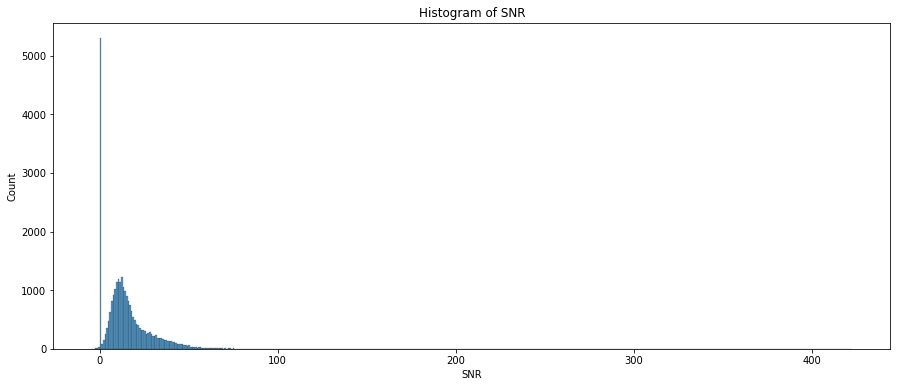

In [ ]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
sns.histplot(clean_data.SNR).set_title('Histogram of SNR')
#sns.scatterplot(x='SNR', y='cough_detected', data=clean_data.loc[clean_data.SNR==0], ax=axarr[1]).set_title('SNR vs. Cough Detected')

In [ ]:
def evaluate_audio(_data, target_dir):
  for index, row in _data.iterrows():
    uuid = row['uuid']
    file_path = row['file_path']
    convert_file(uuid=uuid, file_path=file_path, target_dir=target_dir)
    audio_wav_file = target_dir + str(row['uuid']) + '.wav'
    ipd.display(ipd.Audio(audio_wav_file))

**Evaluate SNR of 0 and remove extreme outlier 400**

In [ ]:
reset_converted_files(audiofile_converted_sample_path)

In [ ]:
import IPython.display as ipd
import librosa
import librosa.display
sample_data = clean_data.loc[clean_data.SNR==0].sample(n=5)

#sample_data = ['fff474bf-39a4-4a61-8348-6b992fb5e439', 'fff3ff61-2387-4139-938b-539db01e6be5', 'ffe5e2a4-ef67-464d-b1cd-b0e321f6a2dd']

In [ ]:
evaluate_audio(_data=sample_data, target_dir=audiofile_converted_sample_path)

Output hidden; open in https://colab.research.google.com to view.

The sample taken from a SNR ratio of 0 do not sound like coughs. The audio file 3330de48-799b-45f9-b13d-0bfe97622003.wav sounded like crickets or birds chirping in the background and the others had no noise.

Based on this sample we will exclude all SNR's with 0 and remove the extreme outlier at 400 to allow a better distribution

In [ ]:
clean_data = clean_data.loc[(clean_data['SNR'] <= 400) & (clean_data['SNR'] > 0)]

Look at histogram again

Text(0.5, 1.0, 'Histogram of SNR')

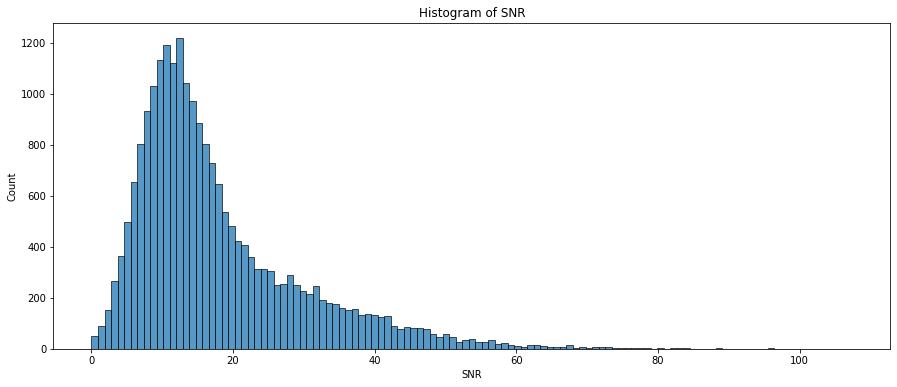

In [ ]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
sns.histplot(clean_data.SNR).set_title('Histogram of SNR')

**Evaluate SNR <= 5**

In [ ]:
sample_data = clean_data.loc[clean_data.SNR<=5].sample(n=5)
evaluate_audio(_data=sample_data, target_dir=audiofile_converted_sample_path)

Output hidden; open in https://colab.research.google.com to view.

Four of the audio files had either music or someone speaking. Based on this input we will remove SNR <= 5

In [ ]:
clean_data = clean_data.loc[(clean_data['SNR'] > 5)]

**Evaluate SNR <= 10**

In [ ]:
sample_data = clean_data.loc[clean_data.SNR<=10].sample(n=5)
evaluate_audio(_data=sample_data, target_dir=audiofile_converted_sample_path)

Output hidden; open in https://colab.research.google.com to view.

Four of the audio files sounded like a cough with some additional background noise. We will consider these to be viable audio files and base further removal on the **cough_detected** value

###Remove data that has a low cough_detected levels

Text(0.5, 1.0, 'Histogram of Cough Detected')

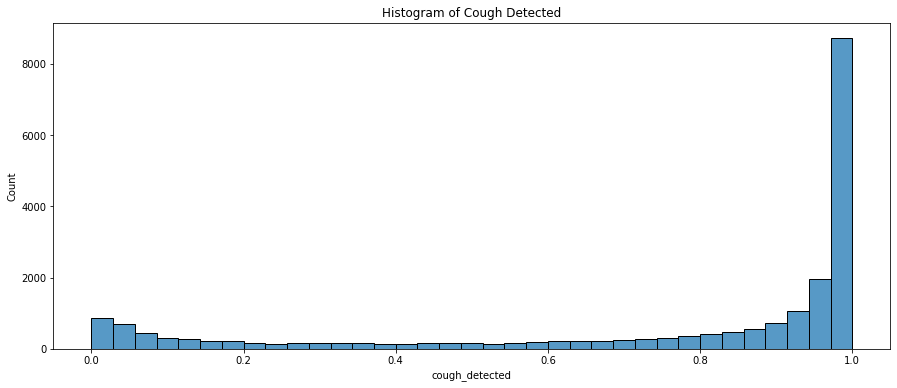

In [ ]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
sns.histplot(clean_data.cough_detected).set_title('Histogram of Cough Detected')

**Evaluate Cough Detected <= 0.2**

In [ ]:
sample_data = clean_data.loc[clean_data.cough_detected<=0.2].sample(n=5)
evaluate_audio(_data=sample_data, target_dir=audiofile_converted_sample_path)

Output hidden; open in https://colab.research.google.com to view.

All of the audio files have background noise impacting a sound of a quality cough that would not be viable data for classification. We will remove cough detected <=0.2

In [ ]:
clean_data = clean_data.loc[(clean_data.cough_detected>0.2)]

**Evaluate Cough Detected <= 0.4**

In [ ]:
sample_data = clean_data.loc[clean_data.cough_detected<=0.4].sample(n=5)
evaluate_audio(_data=sample_data, target_dir=audiofile_converted_sample_path)

Output hidden; open in https://colab.research.google.com to view.

All of the audio files have background noise impacting a sound of a quality cough that would not be viable data for classification. We will remove cough detected <=0.4

In [ ]:
clean_data = clean_data.loc[(clean_data.cough_detected>0.4)]

**Evaluate Cough Detected > 0.7**

In [ ]:
sample_data = clean_data.loc[clean_data.cough_detected>0.7].sample(n=5)
evaluate_audio(_data=sample_data, target_dir=audiofile_converted_sample_path)

Output hidden; open in https://colab.research.google.com to view.

Coughs > 0.7 sound like quality cough audio and we will use this criteria as part of the final dataset

In [ ]:
clean_data = clean_data.loc[(clean_data.cough_detected>0.7)]

### Remove rows where status is null because they cannot be used for classification

In [ ]:
clean_data = clean_data[clean_data.status.notna()]

### Evaluate Clean Data

healthy        8269
symptomatic    1810
COVID-19        665
Name: status, dtype: int64


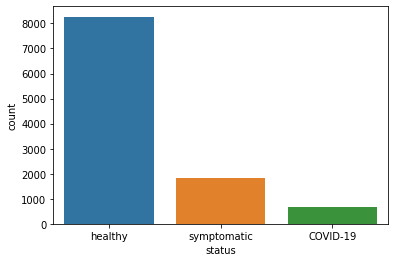

In [ ]:
print(clean_data.status.value_counts())
sns.countplot(x='status', data=clean_data)

Text(0.5, 1.0, 'Cough Detected')

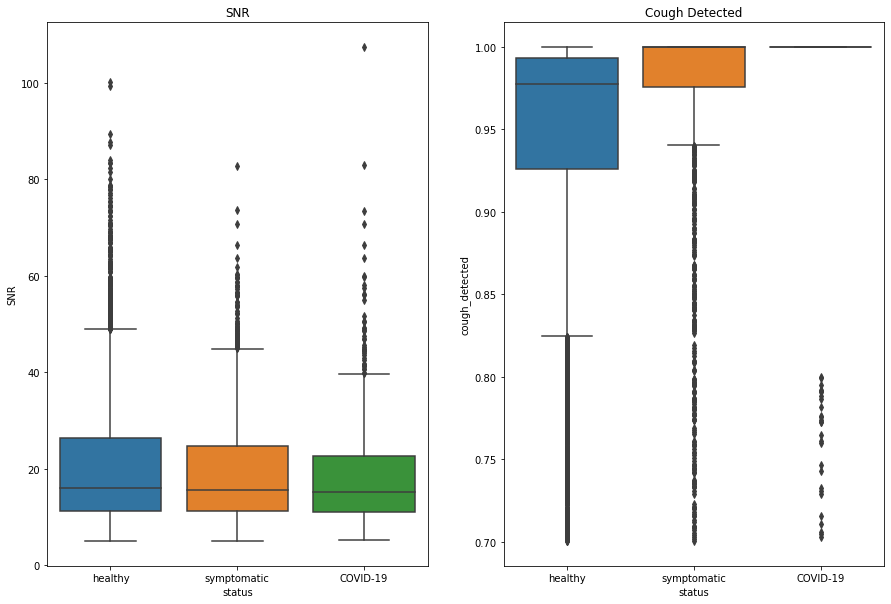

In [ ]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

sns.boxplot(x='status', y='SNR', data=clean_data, ax=axarr[0]).set_title('SNR')
sns.boxplot(x='status', y='cough_detected', data=clean_data, ax=axarr[1]).set_title('Cough Detected')


*   The box plot for SNR shows the median is similar across healthy, symptomatic, and COVID-19 audio files, therefore we will leave this unchanged
*   The box plot for Cough Detected, shows that the cough detected above 0.925 are ideal for healthy, symptomatic, and COVID-19 and the rest are outliers and it is likely that these would be poor audio files to use in classification. Therefore, we will remove these values and look at the distribtion again



**Remove outliers below the lower quartile**

In [ ]:
lower_quantile = np.percentile(clean_data.loc[(clean_data.status=='healthy')].cough_detected, 25)
clean_data = clean_data.loc[(clean_data.cough_detected >= lower_quantile)]

healthy        6203
symptomatic    1567
COVID-19        638
Name: status, dtype: int64


Text(0.5, 1.0, 'Cough Detected')

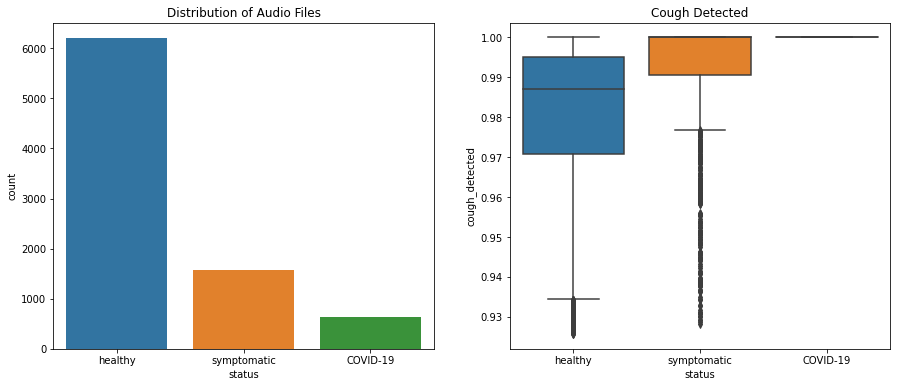

In [ ]:
print(clean_data.status.value_counts())
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
sns.countplot(x='status', data=clean_data, ax=axarr[0]).set_title('Distribution of Audio Files')
sns.boxplot(x='status', y='cough_detected', data=clean_data, ax=axarr[1]).set_title('Cough Detected')

**Sample Healthy Coughs**

In [ ]:
reset_converted_files(target_dir=audiofile_converted_sample_path)
sample_data = clean_data.loc[clean_data.status == 'healthy'].sample(n=5)
evaluate_audio(_data=sample_data, target_dir=audiofile_converted_sample_path)

Output hidden; open in https://colab.research.google.com to view.

**Evaluate Symtomatic Coughs**

In [ ]:
reset_converted_files(target_dir=audiofile_converted_sample_path)
sample_data = clean_data.loc[clean_data.status == 'symptomatic'].sample(n=5)
evaluate_audio(_data=sample_data, target_dir=audiofile_converted_sample_path)

Output hidden; open in https://colab.research.google.com to view.

**Evaluate COVID-19 Coughs**

In [ ]:
reset_converted_files(target_dir=audiofile_converted_sample_path)
sample_data = clean_data.loc[clean_data.status == 'COVID-19'].sample(n=5)
evaluate_audio(_data=sample_data, target_dir=audiofile_converted_sample_path)

Output hidden; open in https://colab.research.google.com to view.

The audio files have been filtered down to be more reliable for training

healthy        6203
symptomatic    1567
COVID-19        638
Name: status, dtype: int64


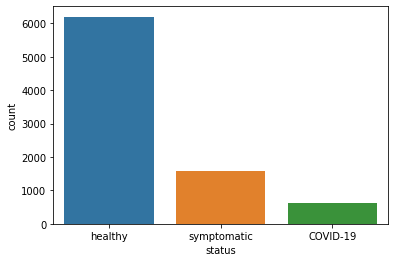

In [ ]:
print(clean_data.status.value_counts())
sns.countplot(x='status', data=clean_data)

### Waves, spectogram, and mfcc of healty, symptomatic, and COVID-19 coughs

In [ ]:
sample_healthy = clean_data.loc[clean_data.status == 'healthy'].sample(n=5)
sample_symptomatic = clean_data.loc[clean_data.status == 'symptomatic'].sample(n=5)
sample_covid19 = clean_data.loc[clean_data.status == 'COVID-19'].sample(n=5)

frames = [sample_healthy, sample_symptomatic, sample_covid19]
sample_set = pd.concat(frames)

In [ ]:
reset_converted_files(target_dir=audiofile_converted_sample_path)

def evaluate_audio_no_display(_data, target_dir):
  for index, row in _data.iterrows():
    uuid = row['uuid']
    file_path = row['file_path']
    convert_file(uuid=uuid, file_path=file_path, target_dir=target_dir)

evaluate_audio_no_display(_data=sample_set, target_dir=audiofile_converted_sample_path)

Successfully converted: /content/gdrive/My Drive/MSDS-498/sample/4d8a104f-5b5b-4ba5-9e75-f34220efee01.wav
Successfully converted: /content/gdrive/My Drive/MSDS-498/sample/e5a85d74-2f40-4d28-9903-75c381c73960.wav
Successfully converted: /content/gdrive/My Drive/MSDS-498/sample/f7b3f5e5-85c2-45e1-a9f4-7014ad0a194b.wav
Successfully converted: /content/gdrive/My Drive/MSDS-498/sample/48aac1b2-829d-4cf1-b164-7fd38eba728b.wav
Successfully converted: /content/gdrive/My Drive/MSDS-498/sample/54d6b720-8c48-4423-a044-7f0c6944453f.wav
Successfully converted: /content/gdrive/My Drive/MSDS-498/sample/6d693261-5807-4ae3-9a60-96cdb5ec1f14.wav
Successfully converted: /content/gdrive/My Drive/MSDS-498/sample/5790906b-44f0-4b59-8052-1f3d7927decd.wav
Successfully converted: /content/gdrive/My Drive/MSDS-498/sample/b9a0045a-0f0b-479c-8771-3624068003d8.wav
Successfully converted: /content/gdrive/My Drive/MSDS-498/sample/1e3025cb-d921-485b-a08c-c2966fc4f730.wav
Successfully converted: /content/gdrive/My Dri

**Wave plot**

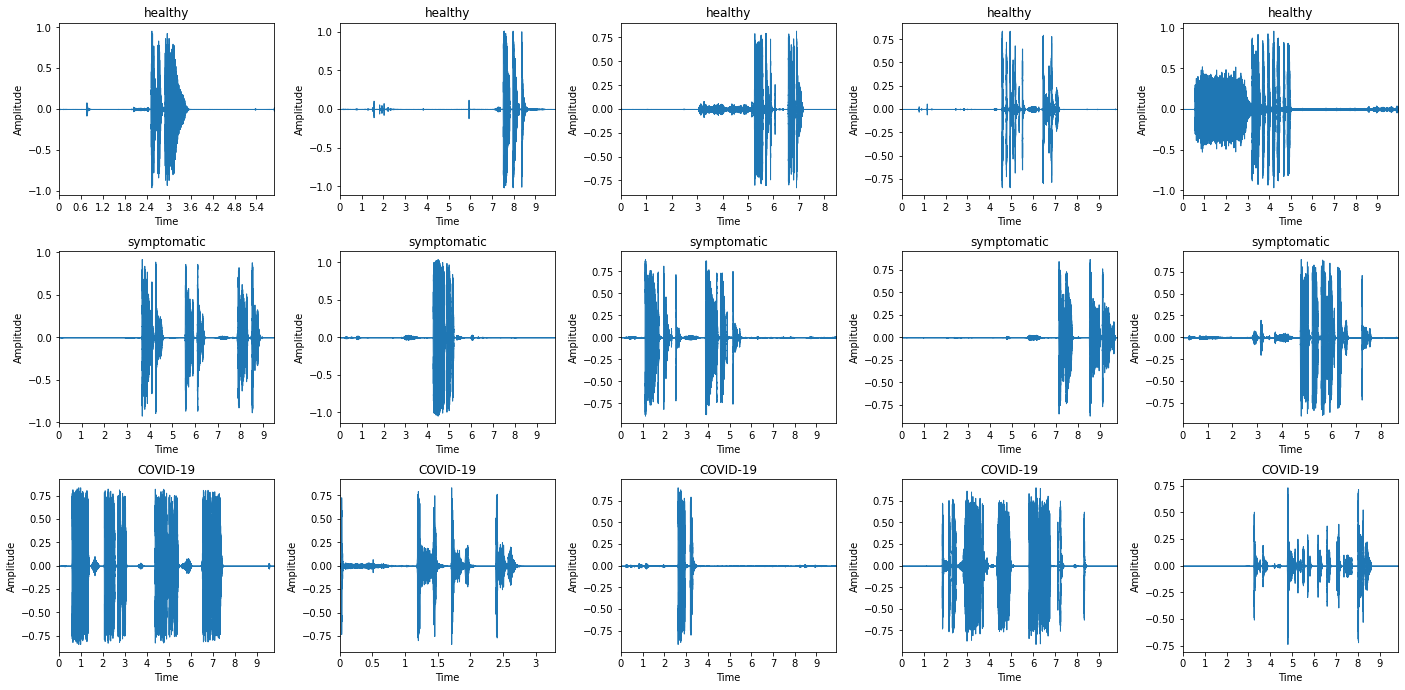

In [ ]:
idx = 0
nrow = -1
ncol = 0

fig, axarr = plt.subplots(nrows=3, ncols=5, figsize=(20,10))
fig.tight_layout(pad=3.5)
for index, row in sample_set.iterrows():
  if idx % 5 == 0:
    nrow += 1
    ncol = 0
  
  converted_file = audiofile_converted_sample_path + str(row['uuid']) + '.wav'
  
  audio, sr = librosa.load(converted_file)
  axarr[nrow, ncol].set_title(str(row['status']))
  axarr[nrow, ncol].set_ylabel('Amplitude')
  librosa.display.waveplot(audio, sr=sr, ax=axarr[nrow, ncol])
  ncol += 1
  idx += 1

There is no sound on some of the audio files at the start and end. Using the librosa library we will trim the start and the end of the sample audio clips to see if it gives a better waveplot

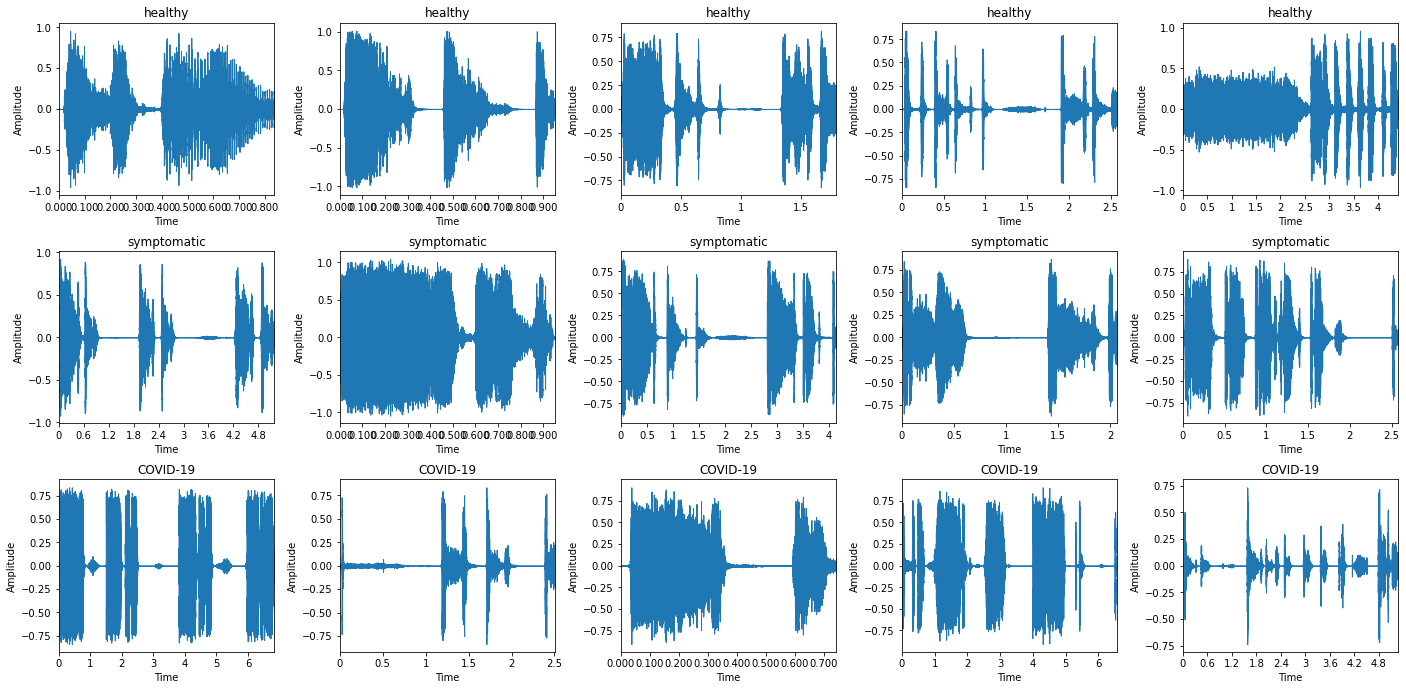

In [ ]:
idx = 0
nrow = -1
ncol = 0

sample_set_trimmed = {}

fig, axarr = plt.subplots(nrows=3, ncols=5, figsize=(20,10))
fig.tight_layout(pad=3.5)
for index, row in sample_set.iterrows():
  if idx % 5 == 0:
    nrow += 1
    ncol = 0

  converted_file = audiofile_converted_sample_path + str(row['uuid']) + '.wav'
  audio, sr = librosa.load(converted_file)
  clip = librosa.effects.trim(audio, top_db=10)

  # save the clip metadata for other graphs
  sample_set_trimmed.update({str(row['uuid']): {'clip': clip[0], 'sr': sr, 'status': str(row['status'])}})

  axarr[nrow, ncol].set_title(str(row['status']))
  axarr[nrow, ncol].set_ylabel('Amplitude')
  librosa.display.waveplot(clip[0], sr=sr, ax=axarr[nrow, ncol])
  ncol += 1
  idx += 1

Trimming reduced the silence before and after the cough recording

**Spectogram - using trimed audio**

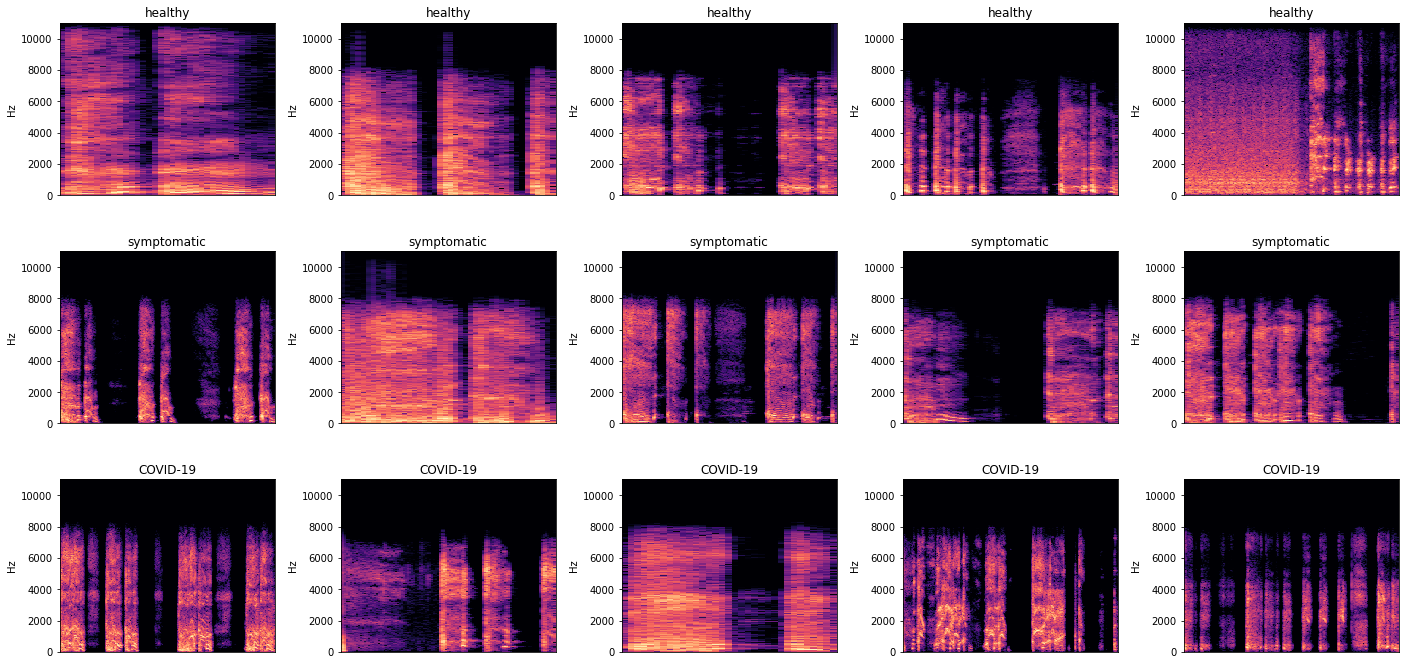

In [ ]:
idx = 0
nrow = -1
ncol = 0

fig, axarr = plt.subplots(nrows=3, ncols=5, figsize=(20,10))
fig.tight_layout(pad=3.5)
for key in sample_set_trimmed.keys():
  if idx % 5 == 0:
    nrow += 1
    ncol = 0
  
  clip = sample_set_trimmed[key]['clip']
  sr = sample_set_trimmed[key]['sr']
  status = sample_set_trimmed[key]['status']

  axarr[nrow, ncol].set_title(status)
  axarr[nrow, ncol].set_xlabel('Time')
  D = librosa.amplitude_to_db(np.abs(librosa.stft(clip)), ref=np.max)
  librosa.display.specshow(D, y_axis='linear', ax=axarr[nrow, ncol])

  ncol += 1
  idx += 1

**Mel-frequency cepstral coefficients (mfcc) - using trimed audio**

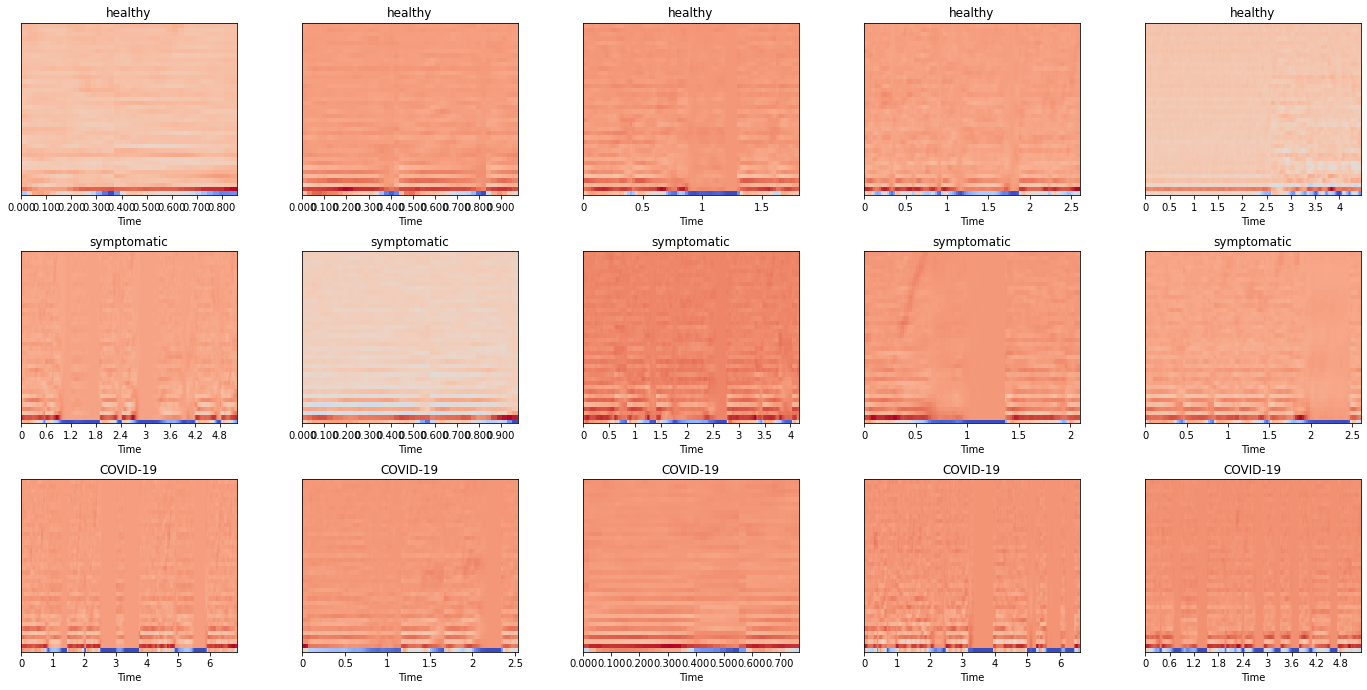

In [ ]:
idx = 0
nrow = -1
ncol = 0

fig, axarr = plt.subplots(nrows=3, ncols=5, figsize=(20,10))
fig.tight_layout(pad=3.5)
for key in sample_set_trimmed.keys():
  if idx % 5 == 0:
    nrow += 1
    ncol = 0
  
  clip = sample_set_trimmed[key]['clip']
  sr = sample_set_trimmed[key]['sr']
  status = sample_set_trimmed[key]['status']

  axarr[nrow, ncol].set_title(status)
  mfcc = librosa.feature.mfcc(y=clip, sr=sr, n_mfcc=40)
  librosa.display.specshow(mfcc, x_axis='time', ax=axarr[nrow, ncol])

  ncol += 1
  idx += 1

**Spectogram and Onset**

A spectrogram is a visual way of representing the signal strength, or loudness” of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

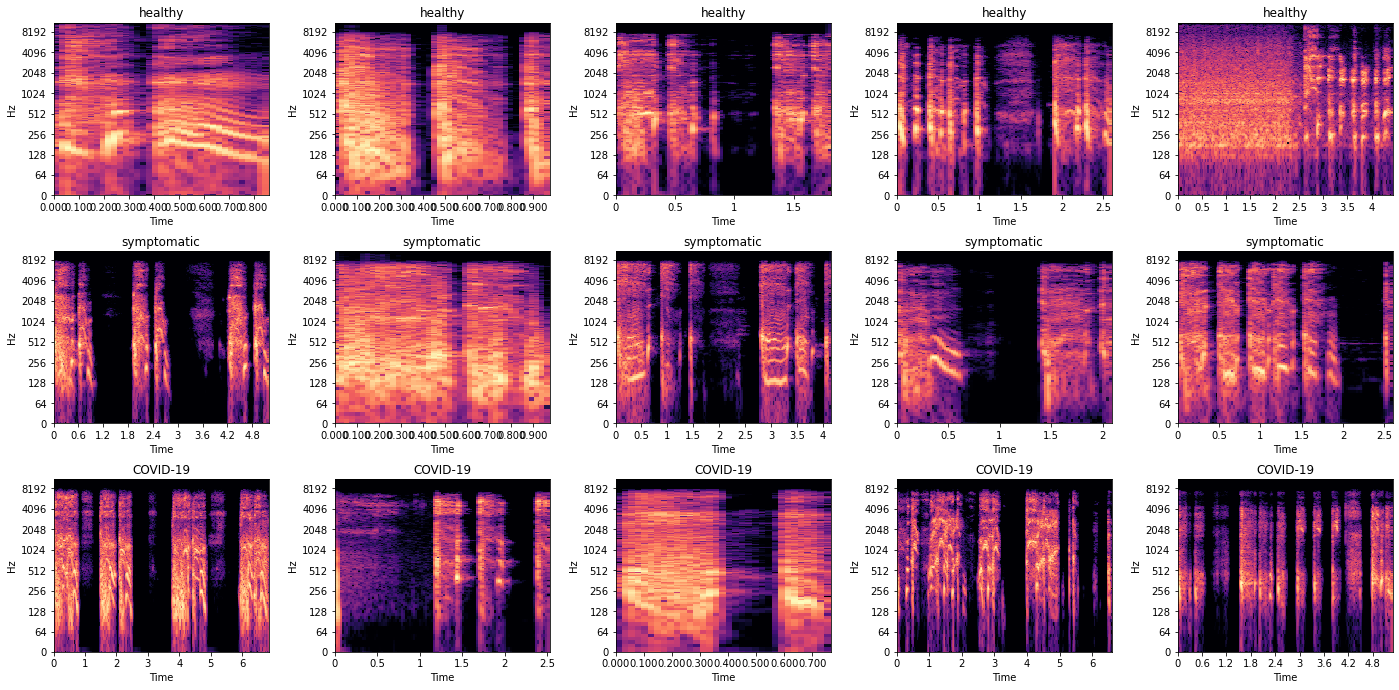

In [ ]:
idx = 0
nrow = -1
ncol = 0

fig, axarr = plt.subplots(nrows=3, ncols=5, figsize=(20,10))
fig.tight_layout(pad=3.5)
for key in sample_set_trimmed.keys():
  if idx % 5 == 0:
    nrow += 1
    ncol = 0
  
  clip = sample_set_trimmed[key]['clip']
  sr = sample_set_trimmed[key]['sr']
  status = sample_set_trimmed[key]['status']

  axarr[nrow, ncol].set_title(status)
  D = np.abs(librosa.stft(clip))
  librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), x_axis='time', y_axis='log', ax=axarr[nrow, ncol])

  ncol += 1
  idx += 1

### Convert all files using the Data Pre-processing

In [ ]:
clean_data.iloc[0].file_path
#audiofile_converted_path + str(clean_data.iloc[0].uuid) + '.wav'

'/content/gdrive/My Drive/MSDS-498/public_dataset/322/00039425-7f3a-42aa-ac13-834aaa2b6b92.webm'

In [ ]:
import soundfile as sf
import time

def trim_audio(audio_file, sub_dir):
  audio, sr = librosa.load(audio_file)
  clip = librosa.effects.trim(audio, top_db=10)
  target_path = os.path.dirname(audio_file) + '/' + str(sub_dir) + '/' + os.path.basename(audio_file)
  shutil.move(audio_file, target_path)
  sf.write(target_path, clip[0], sr)
  
def pre_processed_audio(_data):
  count = 0
  rows = _data.shape[0]
  sub_dir = 1
  reset_converted_files(target_dir=audiofile_converted_path)
  start = time.time()

  for index, row in _data.iterrows():
    target_dir = audiofile_converted_path + str(sub_dir)
    if not os.path.isdir(target_dir):
      os.mkdir(target_dir)

    convert_file(uuid=row['uuid'], file_path=row['file_path'], target_dir=audiofile_converted_path, verbose=False)
    file_name = audiofile_converted_path + str(row['uuid']) + '.wav'
    trim_audio(file_name, sub_dir)
    
    if count % 100 == 0 and count != 0:
      end = time.time()
      duration = end - start
      print('{} / {}: Duration {:.2F}s'.format(count, rows, duration))
      start = time.time()
      sub_dir += 1
    count+=1

if re_run == True:
  pre_processed_audio(clean_data)

100 / 8408: Duration 86.17s
200 / 8408: Duration 86.24s
300 / 8408: Duration 85.40s
400 / 8408: Duration 81.65s
500 / 8408: Duration 83.66s
600 / 8408: Duration 85.21s
700 / 8408: Duration 88.27s
800 / 8408: Duration 84.23s
900 / 8408: Duration 85.11s
1000 / 8408: Duration 87.45s
1100 / 8408: Duration 85.39s
1200 / 8408: Duration 86.11s
1300 / 8408: Duration 85.20s
1400 / 8408: Duration 83.00s
1500 / 8408: Duration 82.77s
1600 / 8408: Duration 82.73s
1700 / 8408: Duration 82.77s
1800 / 8408: Duration 81.86s
1900 / 8408: Duration 85.24s
2000 / 8408: Duration 83.43s
2100 / 8408: Duration 82.45s
2200 / 8408: Duration 84.02s
2300 / 8408: Duration 85.71s
2400 / 8408: Duration 84.50s
2500 / 8408: Duration 83.75s
2600 / 8408: Duration 84.59s
2700 / 8408: Duration 86.50s
2800 / 8408: Duration 85.87s
2900 / 8408: Duration 85.50s
3000 / 8408: Duration 84.15s
3100 / 8408: Duration 86.40s
3200 / 8408: Duration 84.97s
3300 / 8408: Duration 82.80s
3400 / 8408: Duration 84.09s
3500 / 8408: Duration 8

In [ ]:
clean_data.loc[clean_data.uuid=='0009eb28-d8be-4dc1-92bb-907e53bc5c7a']

uuid  ...                                          file_path
3  0009eb28-d8be-4dc1-92bb-907e53bc5c7a  ...  /content/gdrive/My Drive/MSDS-498/public_datas...

[1 rows x 12 columns]

### Duration Distribution of the Audio Clips

In [ ]:
_data = []

for item in os.scandir(audiofile_converted_path):
    if item.is_dir():
        for file in os.scandir(item):
            if file.is_file():
              uuid = os.path.splitext(file.name)[0]
              length = librosa.get_duration(filename = file.path)
              file_path = file.path
              _data.append([uuid, length, file_path])

dataset_for_training = pd.DataFrame(_data, columns=['uuid', 'length', 'file_path'])
dataset_for_training.head(5)

uuid  ...                                          file_path
0  00039425-7f3a-42aa-ac13-834aaa2b6b92  ...  /content/gdrive/My Drive/MSDS-498/converted_fi...
1  0009eb28-d8be-4dc1-92bb-907e53bc5c7a  ...  /content/gdrive/My Drive/MSDS-498/converted_fi...
2  001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f  ...  /content/gdrive/My Drive/MSDS-498/converted_fi...
3  00291cce-36a0-4a29-9e2d-c1d96ca17242  ...  /content/gdrive/My Drive/MSDS-498/converted_fi...
4  0029d048-898a-4c70-89c7-0815cdcf7391  ...  /content/gdrive/My Drive/MSDS-498/converted_fi...

[5 rows x 3 columns]

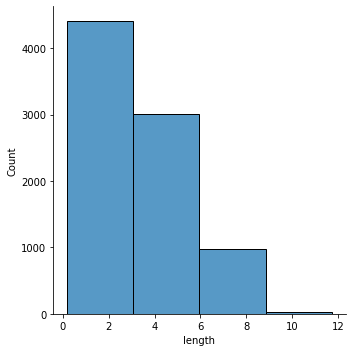

In [ ]:
p = sns.displot(data=dataset_for_training.length, bins=4)

Most of the audio files are less than 3 and 6 seconds. A sample will be taken to see how viable the audio files are and if we should clip the audio to be consistent

**Sample: 'audio length'**

Sample : <1

In [ ]:
reset_converted_files(target_dir=audiofile_converted_sample_path)
sample_data = dataset_for_training.loc[(dataset_for_training.length <= 1)].sample(n=5)

evaluate_audio(_data=sample_data, target_dir=audiofile_converted_sample_path)

Successfully converted: /content/gdrive/My Drive/MSDS-498/sample/b1df4b23-b23c-42c1-9aef-795ea5aa6991.wav


Successfully converted: /content/gdrive/My Drive/MSDS-498/sample/e86c5c4a-b29f-41f3-83c3-2ad6cc6e258b.wav


Successfully converted: /content/gdrive/My Drive/MSDS-498/sample/156a89ec-ec1d-471e-a47b-5c2b9f93de6e.wav


Successfully converted: /content/gdrive/My Drive/MSDS-498/sample/6c7893ac-4ca9-47af-8a91-fd0926dd7f39.wav


Successfully converted: /content/gdrive/My Drive/MSDS-498/sample/5095967b-959c-4743-8024-aa4b0332c62b.wav


Sample: >1 and <= 1.5

In [ ]:
reset_converted_files(target_dir=audiofile_converted_sample_path)
sample_data = dataset_for_training.loc[(dataset_for_training.length > 1) & (dataset_for_training.length <=1.5)].sample(n=5)

evaluate_audio(_data=sample_data, target_dir=audiofile_converted_sample_path)

Successfully converted: /content/gdrive/My Drive/MSDS-498/sample/f14844bc-d46b-405b-a424-c23ba3156a27.wav


Successfully converted: /content/gdrive/My Drive/MSDS-498/sample/2e337e32-fa03-4eee-828d-6278612b7f51.wav


Successfully converted: /content/gdrive/My Drive/MSDS-498/sample/24526b28-3377-4f1e-942f-8e3f6d38e44b.wav


Successfully converted: /content/gdrive/My Drive/MSDS-498/sample/c52f9edf-409b-46dc-8d99-b0b6e0e3a336.wav


Successfully converted: /content/gdrive/My Drive/MSDS-498/sample/793a1a51-7759-42c9-a783-332f9e7880ff.wav


The samples appear to have enough time to be usable if the audio is great than 1. Therefore, Audio >= 1 will be used and will be limited to 1.5 seconds since 1.5 seems to be enough time to record a series of coughs

##Create dataset for training##

In [ ]:
duration_limit = 1.5

In [ ]:
from sklearn.preprocessing import LabelEncoder
dataset_for_training = pd.DataFrame(_data, columns=['uuid', 'length', 'file_path'])
dataset_for_training = dataset_for_training.loc[(dataset_for_training.length >= duration_limit)]
dataset_for_training = dataset_for_training.merge(clean_data[['uuid', 'datetime', 'cough_detected', 'SNR', 'status']], how='left', on='uuid')


label_encoder = LabelEncoder()
dataset_for_training['label'] = label_encoder.fit_transform(dataset_for_training.status)

dataset_for_training.to_csv(audiofile_converted_path + 'metadata_compiled.csv')
dataset_for_training.head()

uuid    length  ...       status label
0  00039425-7f3a-42aa-ac13-834aaa2b6b92  4.179592  ...      healthy     1
1  0009eb28-d8be-4dc1-92bb-907e53bc5c7a  3.134694  ...      healthy     1
2  001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f  3.390113  ...      healthy     1
3  00291cce-36a0-4a29-9e2d-c1d96ca17242  6.013968  ...      healthy     1
4  0029d048-898a-4c70-89c7-0815cdcf7391  5.154830  ...  symptomatic     2

[5 rows x 8 columns]

healthy        4391
symptomatic    1182
COVID-19        478
Name: status, dtype: int64


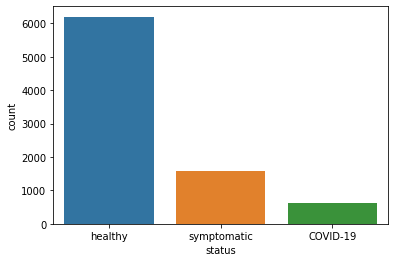

In [ ]:
print(dataset_for_training.status.value_counts())
sns.countplot(x='status', data=clean_data)

Create even distribution of data, 450 each

In [ ]:
sample_healthy = dataset_for_training.loc[dataset_for_training.status == 'healthy'].sample(n=450)
sample_symptomatic = dataset_for_training.loc[dataset_for_training.status == 'symptomatic'].sample(n=450)
sample_covid19 = dataset_for_training.loc[dataset_for_training.status == 'COVID-19'].sample(n=450)

frames = [sample_healthy, sample_symptomatic, sample_covid19]
dataset_for_training_sample = pd.concat(frames)

healthy        4391
symptomatic    1182
COVID-19        478
Name: status, dtype: int64


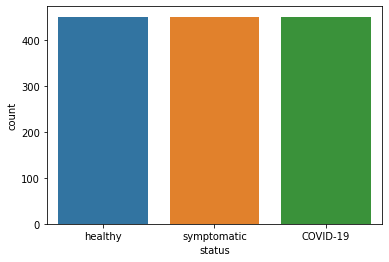

In [ ]:
print(dataset_for_training.status.value_counts())
sns.countplot(x='status', data=dataset_for_training_sample)

In [ ]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def generate_train_test_data(_data, test_size=0.2, reshape=True):
  x_train, x_test, Y_train, Y_test = [], [], [], []

  for index in tqdm(range(len(_data))):
  #for index, row in dataset_for_training.iterrows():
    file_path = _data.iloc[index]['file_path']
    label = _data.iloc[index]['label']

    # extract features
    audio, sampling_rate = librosa.load(file_path, duration=duration_limit)
    signal_length = len(audio)

    audio = librosa.util.normalize(audio)
    mel_spectrogram = librosa.feature.melspectrogram(audio, sr=sampling_rate, n_mels=64)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(mel_spectrogram), n_mfcc=128)

    x_train.append(mfccs)
    Y_train.append(label)
  

  x_train = np.asarray(x_train)
  if reshape:
    # Reshape to 2-D numpry array for training
    n_samples, x, y = x_train.shape
    x_train = x_train.reshape((n_samples, x*y))

  #x_train, x_test, Y_train, Y_test =train_test_split(x_train, Y_train, stratify=Y_train, test_size=0.2)
  x_train, x_test, Y_train, Y_test =train_test_split(x_train, Y_train, test_size=0.2)

  return x_train, x_test, Y_train, Y_test

In [ ]:
x_train, x_test, Y_train, Y_test = generate_train_test_data(_data=dataset_for_training_sample, test_size=0.2)

100%|██████████| 1350/1350 [00:15<00:00, 89.42it/s] 


Text(0.5, 1.0, 'Class Distribution of Test')

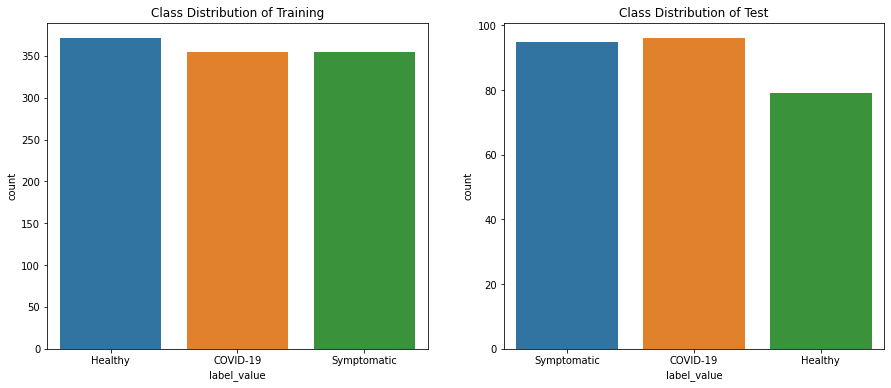

In [ ]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

label_mapping = {0: 'COVID-19', 1: 'Healthy', 2: 'Symptomatic'}
x_train_df = pd.DataFrame(Y_train, columns=['status'])
x_train_df['label_value'] = x_train_df.status.apply(lambda x: label_mapping.get(x))
x_test_df = pd.DataFrame(Y_test, columns=['status'])
x_test_df['label_value'] = x_test_df.status.apply(lambda x: label_mapping.get(x))

sns.countplot(x='label_value', data=x_train_df, ax=axarr[0]).set_title('Class Distribution of Training')
sns.countplot(x='label_value', data=x_test_df, ax=axarr[1]).set_title('Class Distribution of Test')

## Evaluate Random Forest Classifer ##

A random forest classifer will be used to validate how well the cleanup of the audio files is and be used as an indicator if more cleanup is required before trying out different classification methods (e.g., logistic regression, deep neural networks, convolutinal neural networks, etc.)

Müller and Guido (2017) suggest using max_features = ‘log2’ for random forest regression problems and max_features = ‘sqrt’ for classification problems.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

variables = x_train.shape[1]

start = time.time()

parameters = {'max_depth': 10, 'max_features': 'sqrt',  'min_samples_leaf': 2,  'min_samples_split': 4, 'n_estimators': 1800}
rf = make_pipeline(RandomForestClassifier(**parameters))
print(rf)
rf.fit(x_train, Y_train)
end = time.time()
duration = end - start

print('...Completed Random Forest Classifier using {} estimators: Duration {:.2F}s'.format(variables, duration))

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        min_samples_leaf=2, min_samples_split=4,
                                        n_estimators=1800))])
...Completed Random Forest Classifier using 4160 estimators: Duration 58.85s


In [ ]:
# Prediction
Y_train_pred = rf.predict(x_train)
Y_test_pred = rf.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_test_pred, zero_division=1, target_names=['COVID-19', 'Healthy', 'Symptomatic']))
print(label_mapping)

              precision    recall  f1-score   support

    COVID-19       0.46      0.60      0.52        93
     Healthy       0.38      0.25      0.30        95
 Symptomatic       0.31      0.32      0.32        82

    accuracy                           0.39       270
   macro avg       0.38      0.39      0.38       270
weighted avg       0.38      0.39      0.38       270

{0: 'COVID-19', 1: 'Healthy', 2: 'Symptomatic'}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=3000, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 511, 822, 1133, 1444, 1755, 2066, 2377, 2688, 3000]}

In [ ]:
if re_run == True:
  rf = RandomForestClassifier()
  # Random search of parameters using 3 fold cross validation
  rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
  #rf_random.fit(x_train, Y_train)

In [ ]:
#rf_random.best_params_

## Evaluate CNN ##

In [ ]:
x_train, x_test, Y_train, Y_test = generate_train_test_data(_data=dataset_for_training_sample, test_size=0.2, reshape=False)

100%|██████████| 1350/1350 [00:11<00:00, 114.09it/s]


In [ ]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

x_train_cnn = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test_cnn = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
Y_train_cnn = to_categorical(Y_train)
Y_test_cnn = to_categorical(Y_test)

print('X train: {}'.format(x_train_cnn.shape))
print('X test: {}'.format(x_test_cnn.shape))
print('Y train: {}'.format(Y_train_cnn.shape))
print('Y test: {}'.format(Y_test_cnn.shape))

X train: (1080, 64, 65, 1)
X test: (270, 64, 65, 1)
Y train: (1080, 3)
Y test: (270, 3)


In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

model = models.Sequential()
# 1
model.add(layers.Conv2D(filters=16, kernel_size=2, input_shape=(x_train_cnn.shape[1], x_train_cnn.shape[2], x_train_cnn.shape[3]), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.2))
#2
model.add(layers.Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.2))
#3
model.add(layers.Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.2))
#4
model.add(layers.Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.5))
model.add(layers.GlobalAveragePooling2D())
#output
model.add(layers.Flatten())
model.add(layers.Dense(units=len(label_encoder.classes_)))

optimizer = optimizers.SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 63, 64, 16)        80        
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 31, 32, 16)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 31, 32, 16)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 30, 31, 32)        2080      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 15, 15, 32)       

In [ ]:
save_best_callback = callbacks.ModelCheckpoint(filepath=audiofile_converted_path+'cnn_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
#reduce_lr_callback = callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=10, min_lr=1e-6, factor=0.2)

history = model.fit(x_train_cnn, Y_train_cnn, batch_size=128, epochs=1000, validation_data=(x_test_cnn, Y_test_cnn), callbacks=[save_best_callback])
#model.save(filepath=audiofile_converted_path+'cnn_model.h5')

Epoch 1/1000
7/9 [======================>.......] - ETA: 0s - loss: 2.3267 - accuracy: 0.3292
Epoch 00001: val_accuracy improved from -inf to 0.28519, saving model to /content/gdrive/My Drive/MSDS-498/converted_files/cnn_model.h5
9/9 [==============================] - 1s 77ms/step - loss: 2.1231 - accuracy: 0.3417 - val_loss: 1.1677 - val_accuracy: 0.2852
Epoch 2/1000
7/9 [======================>.......] - ETA: 0s - loss: 1.1448 - accuracy: 0.3415
Epoch 00002: val_accuracy did not improve from 0.28519
9/9 [==============================] - 0s 20ms/step - loss: 1.1433 - accuracy: 0.3444 - val_loss: 1.1244 - val_accuracy: 0.2852
Epoch 3/1000
9/9 [==============================] - ETA: 0s - loss: 1.1140 - accuracy: 0.3528
Epoch 00003: val_accuracy did not improve from 0.28519
9/9 [==============================] - 0s 18ms/step - loss: 1.1140 - accuracy: 0.3528 - val_loss: 1.1083 - val_accuracy: 0.2852
Epoch 4/1000
5/9 [===============>..............] - ETA: 0s - loss: 1.1096 - accuracy: 0

In [ ]:
import pickle
pickle_out = open(audiofile_converted_path+'cnn_history.pkl', 'wb')
pickle.dump(history, pickle_out)
pickle_out.close()

INFO:tensorflow:Assets written to: ram://9c782933-f35e-481b-9a11-83810d1e127d/assets


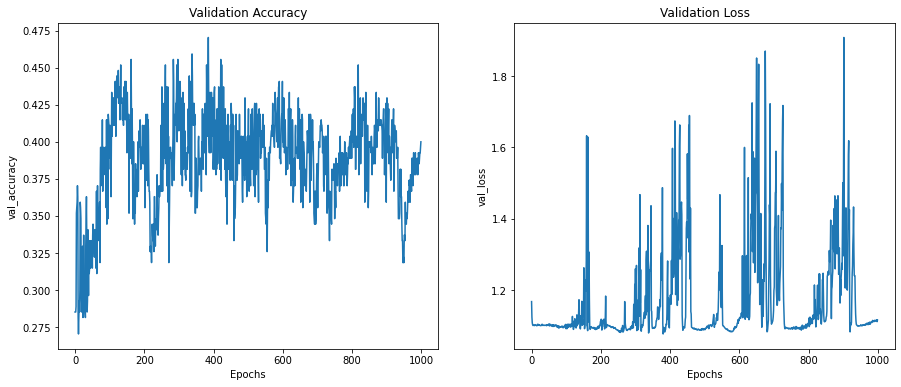

In [ ]:
cnn_results = pd.DataFrame(history.history)

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
p1 = sns.lineplot(data=cnn_results, y='val_accuracy', x=range(cnn_results.shape[0]), ax=axarr[0]).set_title('Validation Accuracy')
p2 = sns.lineplot(data=cnn_results, y='val_loss', x=range(cnn_results.shape[0]), ax=axarr[1]).set_title('Validation Loss')

axarr[0].set_xlabel('Epochs')
axarr[1].set_xlabel('Epochs')

plt.show()

In [ ]:
# Prediction
best_model = models.load_model(filepath=audiofile_converted_path+'cnn_model.h5')
Y_train_pred = best_model.predict(x_train).argmax(axis=-1)
Y_test_pred = best_model.predict(x_test).argmax(axis=-1)
print(classification_report(Y_test, Y_test_pred, zero_division=1, target_names=['COVID-19', 'Healthy', 'Symptomatic']))
print(label_mapping)

              precision    recall  f1-score   support

    COVID-19       0.46      0.71      0.56        94
     Healthy       0.45      0.17      0.25        77
 Symptomatic       0.50      0.47      0.49        99

    accuracy                           0.47       270
   macro avg       0.47      0.45      0.43       270
weighted avg       0.47      0.47      0.44       270

{0: 'COVID-19', 1: 'Healthy', 2: 'Symptomatic'}
